## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 3 (30 pkt.)
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: twoje imię i nazwisko + numer indeksu

## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki OpenAI Gym (https://gym.openai.com): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [1]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install "gymnasium[box2d]==0.28" torch matplotlib numpy
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

'pip' is not recognized as an internal or external command,
operable program or batch file.


### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gym.openai.com/envs/CartPole-v1) i `LunarLander` (https://gym.openai.com/envs/LunarLander-v2/).

In [1]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gymnasium as gym
import pandas as pd
import numpy as np

# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, term, trunc, _= env.step(action)
    # print(term, trunc)
    done = term or trunc

    if done:
        observation = env.reset()
env.close()

c:\Users\Dell Latitude\AppData\Local\Programs\Python\Python38\lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


In [2]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

Przestrzeń stanów: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Rozmiar wektora reprezntującego stany: (8,)
Ostatnia obserwacja: <class 'numpy.ndarray'> [ 0.05957794  1.2934169   0.33788317 -0.48074207 -0.06748179  0.04117891
  0.          0.        ]
Przestrzeń akcji: Discrete(4)
Ilość możliwych akcji: 4


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziiesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [3]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [4]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards, eps):
    fig, ax = plt.subplots()
    ax.plot(rewards)
    ax2 = ax.twinx()
    ax2.plot(eps, label='epsilon', color='k')
    ax2.legend(loc='lower left')
    ax2.grid(False)
    ax2.set_ylim(0, 1)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000, target=None, window=None):
    rewards = []
    eps = []
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        eps.append(agent.epsilon)

        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards, eps)

    return rewards    

In [5]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    
    def process_transition(self, observation, action, reward, next_observation, done):
        pass
        
    def get_action(self, observation, learning):
        return self.action_space.sample()
    
random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

AttributeError: 'RandomAgent' object has no attribute 'epsilon'

## Zad. 3.1 - Tabularyczny Q-Learning (5 pkt.)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przestrzeń stanów, musisz dokonać odpowiedniej dyskretyzacji stanów.

Odpowiedź na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `TabularQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Obserwujemy spadek jakości ze względu na zmiany współczynników alpha i epsilon, które stają się coraz mniejsze w celu znalezienia lepszej polityki i mogą pogorszyć uzyskane dobre wyniki. Możemy temu zaradzić poprzez zakończenie uczenia po osiągnięciu satysfakcjonujących rezultatów. Kryterium jakości może być np. przekroczenie określonego celu przez ostatnie *n* epizodów.

In [5]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, alpha=0.4, gamma=0.99, epsilon=0.9, eps_decay=0.999, alpha_decay=0.999):
        super().__init__(env)
        self.alpha, self.gamma, self.epsilon, self.eps_decay, self.alpha_decay = alpha, gamma, epsilon, eps_decay, alpha_decay
        self.maxes = np.array([4.8, 3, 0.42, 3])
        self.ranges = np.array([10, 20, 10, 20])
        self.mins = -self.maxes
        np.random.seed(123)
        # print([env.action_space.n])
        self.Q = np.random.uniform(low=0, high=3, size=(np.concatenate([self.ranges, [env.action_space.n]])))
        # print(self.Q)
    
    def discretize(self, obs, bin=10):
        if len(obs) == 2:
            obs = obs[0]
        # print(obs)
        discrete_series = (np.clip(obs, self.mins, self.maxes) - self.mins) / (self.maxes - self.mins)
        discrete_series = np.round((self.ranges - 1) * discrete_series)
        # discrete_series = obs / self.maxes + np.array([15, 10, 1, 10])
        return tuple(discrete_series.astype(int))


    def process_transition(self, observation, action, reward, next_observation, done):
        s, s_next = self.discretize(observation), self.discretize(next_observation)
        if done:
            self.epsilon = max(self.epsilon * self.eps_decay, 0)
            self.alpha = max(self.alpha * self.alpha_decay, 0)
        max_future_q = np.max(self.Q[s_next])
        current_q = self.Q[s + (action,)]
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        self.Q[s + (action,)] = new_q
        # self.Q[s][action] += self.alpha * (reward + self.gamma * np.max(self.Q[s_next]) - self.Q[s][action])
        
    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.epsilon:
            a = np.random.randint(self.action_space.n)
        else:
            s = self.discretize(observation)
            a = np.argmax(self.Q[s])
        return a

233.31966666666668


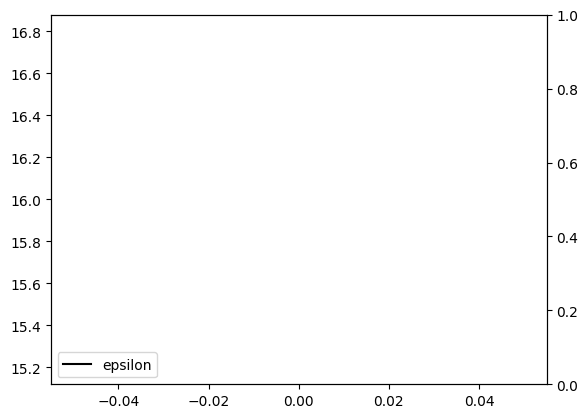

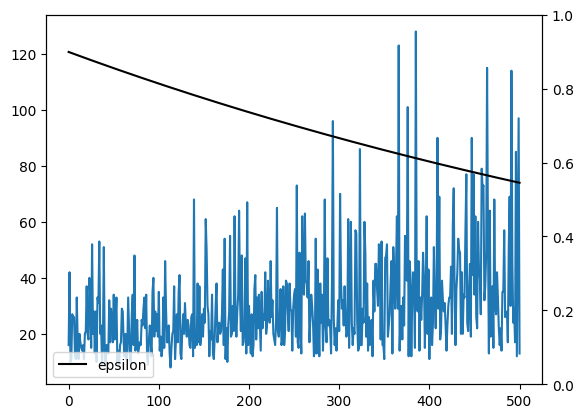

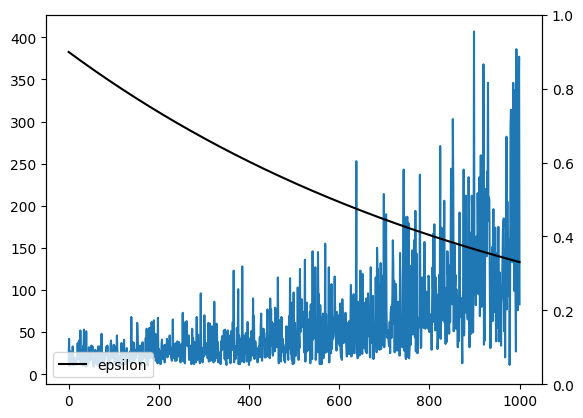

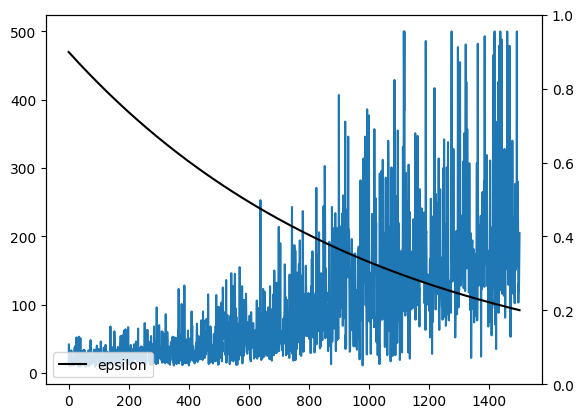

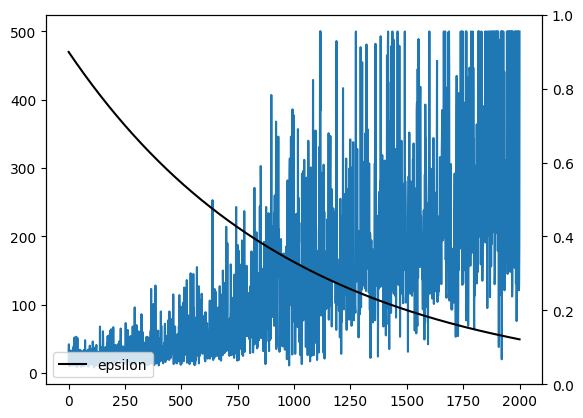

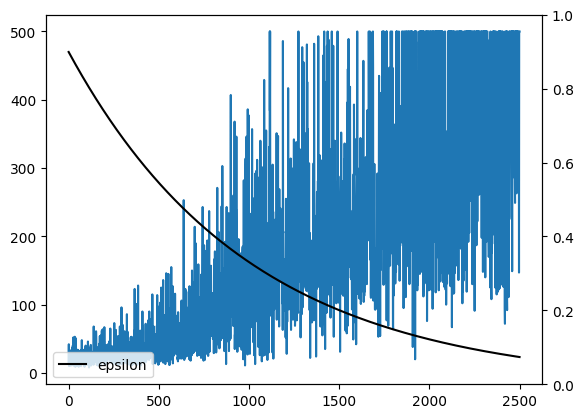

In [6]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 3000, learning=True, plot=True, plot_interval=500)
print(np.mean(np.array(rewards)))

## Zad. 3.2 - Q-Learning z aproksymacją (25 pkt.)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również, jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powinna mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj, by domyślnie Twoja implementacja działała na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architekturę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `NeuralQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Wartości parametrów zostały dobrane na podstawie kilku eksperymentów, głównie na implementacji czystego wariantu algorytmu Q-learning. Na tej podstawie dobrałem wartość epsilona - 0.5 zauważając, że dla mniejszych wartości krzywa uczenia jest bardziej stabilna. Dla współczynnika dyskontującego równego 0.99 Q-learning osiągał najlepsze rezultaty (inne testowane wartości to np. 0.3, 0.7, 0.99). Wielkości wewnętrzych warst sieci neuronowej zostały dobrane na podstawie przetargu wartości wyników/czas uczenia - dla wariantów z pamięcią były 2 razy mniejsze. Pozostałe parametry nie miały dużego wpływu na uzyskiwane wyniki (może poza ekstremalnymi ich wartościami).

Wyniki z poszczególnych wariantów charakteryzują się, po przekroczeniu pewnej wartości epsilon, stabilną krzywą uczenia. Warianty wykorzystujące replay memory uzyskują lepsze wyniki, gdzie w połączeniu z network freezing algorytm osiąga wartości bliskie zakładanemu celu dla 1500 epizodów. Stabilna krzywa uczenia sugeruje, że dla większej liczby epizodów średnia algorytmu będzie jeszcze bliższa 100 lub nawet lepsza. 

In [7]:
import torch
from random import random
import torch
import torch.nn.functional as F
from copy import deepcopy

In [8]:
class MyModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(MyModel, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # Warstwa wejściowa/pierwsza ukryta
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)         # Druga warstwa ukryta
        self.predict = torch.nn.Linear(n_hidden2, n_output)   # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.predict(x)
        return x

    

In [26]:
class NeuralQLearningAgent(Agent):
    def __init__(self, env, epsilon=0.99, gamma=0.99, hidden=[256, 128], batch_size=64, eps_decay=0.997, memory_capacity=1500, C=20, replay_memory=True, freezing=True, double_q=True):
        super().__init__(env)
        self.epsilon = epsilon
        self.h = MyModel(env.observation_space.shape[0], *hidden, env.action_space.n)
        self.optim = torch.optim.Adam(self.h.parameters(), lr=0.0001, weight_decay=0.0001)
        self.loss_func = torch.nn.MSELoss()
        self.gamma = gamma
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.replay_memory = replay_memory
        self.double_q = double_q
        self.Q = deepcopy(self.h) if freezing else self.h
        self.freezing = freezing
        self.steps = 0
        self.C = C
        # memory helpers
        self.memory_capacity, self.memory_index, self.memory_size = memory_capacity, 0, 0
        self.actions, self.rewards = torch.zeros(memory_capacity), torch.zeros(memory_capacity)
        self.observations, self.next_observations = torch.zeros((memory_capacity, env.observation_space.shape[0])), torch.zeros((memory_capacity, env.observation_space.shape[0]))
        self.done = torch.zeros(memory_capacity).bool()
        # Zainicjalizuj tutaj swojego agenta

   
    def append_memory(self, a, r, s, s_next, done):
       index = self.memory_index
       self.actions[index], self.rewards[index], self.observations[index], self.next_observations[index], self.done[index] = a, r, s, s_next, done
       self.memory_index = (self.memory_index + 1) % self.memory_capacity
       self.memory_size = min(self.memory_size + 1, self.memory_capacity)

    def predict(self, h, S):
        with torch.no_grad():  # Wyłączenie liczenia gradientów dla bloku poniżej
            return h(torch.Tensor(S))
    
    def process_transition(self, observation, action, reward, next_observation, done):

      if len(observation) == 2:
         observation = observation[0]
      
      observation, next_observation, done_t = torch.Tensor(observation), torch.Tensor(next_observation), torch.tensor(done).bool()

      self.steps += 1
      self.optim.zero_grad()
      self.append_memory(action, reward, observation, next_observation, done_t)

      if self.replay_memory:
         if self.memory_size < self.batch_size:
            return
         permutation = torch.randperm(self.memory_size)[:self.batch_size]
         action, reward, observation, next_observation, done_t = \
                                 self.actions[permutation], self.rewards[permutation], self.observations[permutation], self.next_observations[permutation], self.done[permutation]
      else:
         i, j = self.memory_index - 1, self.memory_index
         action, reward, observation, next_observation, done_t = \
                                 self.actions[i:j], self.rewards[i:j], self.observations[i:j], self.next_observations[i:j], self.done[i:j]
         self.memory_index -= 1
        
      if self.double_q:
         next_a = self.h(next_observation).argmax(1).long().unsqueeze(1)
         next_q = self.Q(next_observation).gather(1, next_a).reshape(-1)
      else:
         next_q = self.Q(next_observation).max(1).values

      y = (reward + self.gamma * next_q) * ~done_t
      Y = self.h(observation).gather(1, action.long().unsqueeze(1)).reshape(-1)

      loss = self.loss_func(Y, y)

      loss.backward()
      self.optim.step()

      if done: 
         self.epsilon = max(self.epsilon * self.eps_decay, 0.1)
        
      if self.freezing and self.steps % self.C == 0:
         self.Q.load_state_dict(self.h.state_dict())
   
        
    def get_action(self, observation, learning):
        # Wybór kolejnej akcji - implementacja polityki epsilon-greedy
        if learning and np.random.rand() < self.epsilon:
            A = np.random.randint(self.action_space.n)
        else:
            if len(observation) == 2:
               observation = observation[0]
            # s = torch.Tensor(observation).unsqueeze(0)
            Q = self.predict(self.h, observation)
            # A = self.h(s).argmax()
            A = torch.argmax(Q).item()
        return A

In [27]:
# Uczenie/testowania agenta
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, replay_memory=False, double_q=False, freezing=False)
# rewards = run_agent_in_env(env, agent, 3000, learning=True, plot=True, plot_interval=250)

tensor(-383.5823)


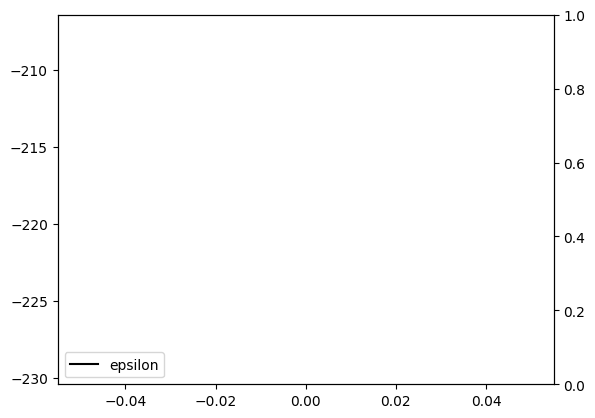

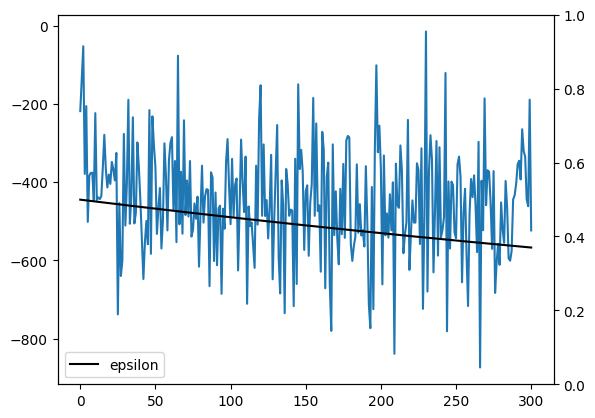

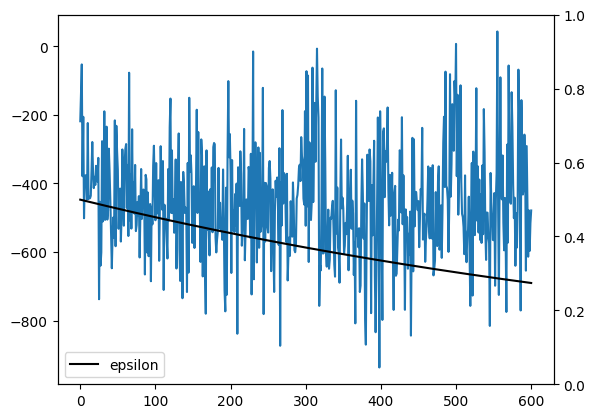

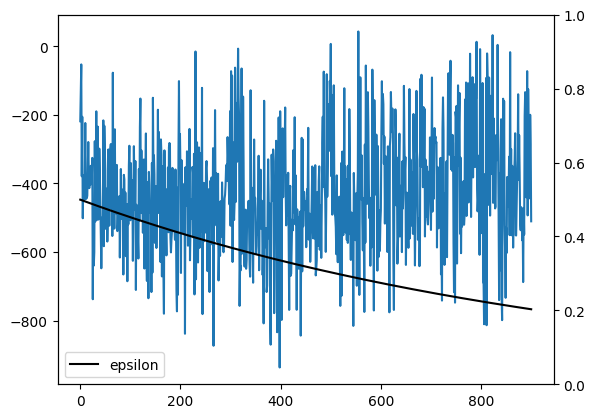

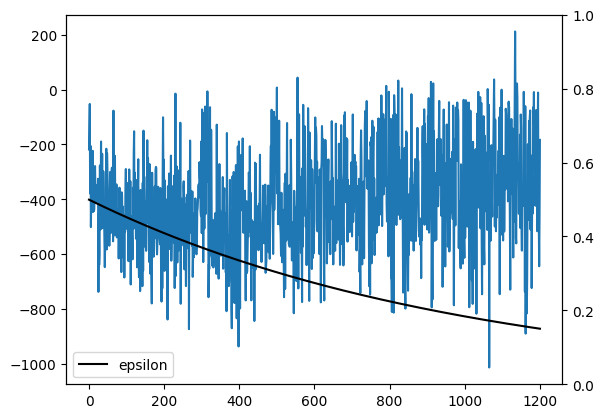

In [23]:
rewards1 = run_agent_in_env(env, agent, 1500, learning=True, plot=True, plot_interval=300)
rewards1 = torch.Tensor(rewards1)
print(rewards1.mean())

tensor(9.7445)


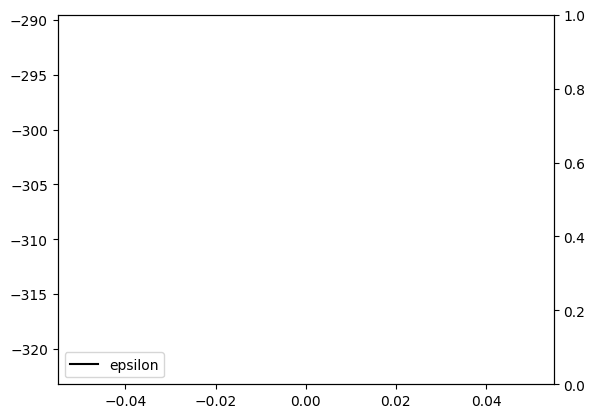

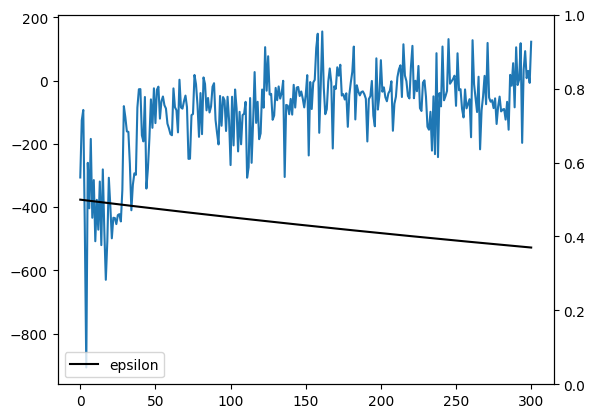

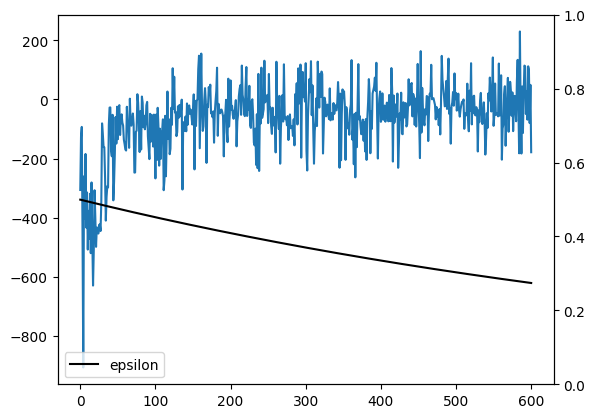

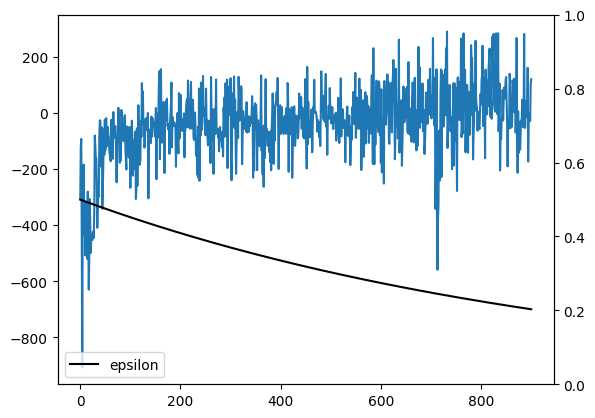

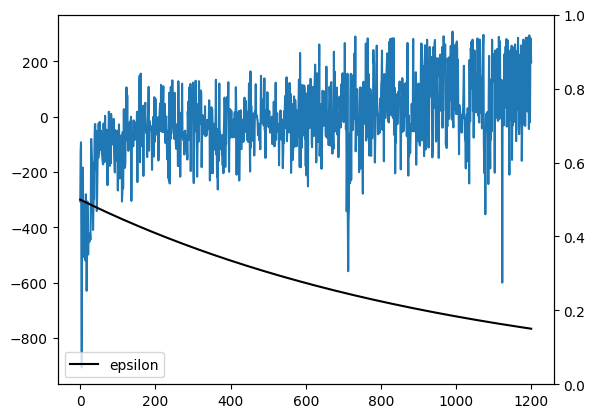

In [22]:
env = gym.make("LunarLander-v2")
agent2 = NeuralQLearningAgent(env, hidden=[128, 64], replay_memory=True, double_q=False, freezing=False)
rewards2 = run_agent_in_env(env, agent2, 1500, learning=True, plot=True, plot_interval=300)
print(torch.Tensor(rewards2).mean())

tensor(78.0381)


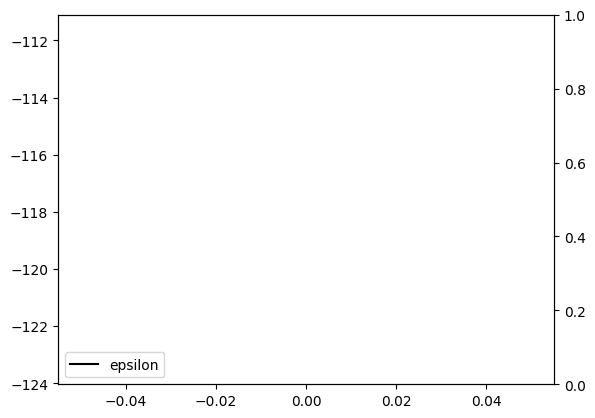

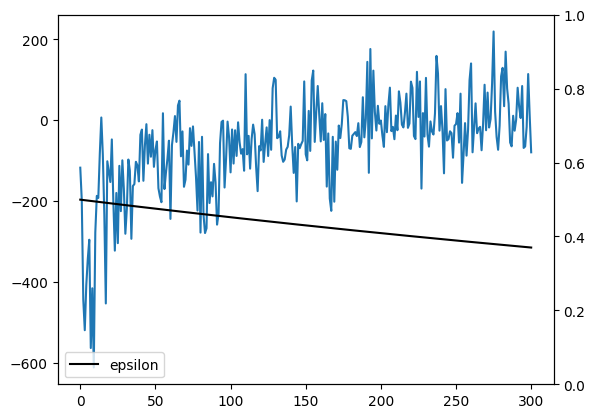

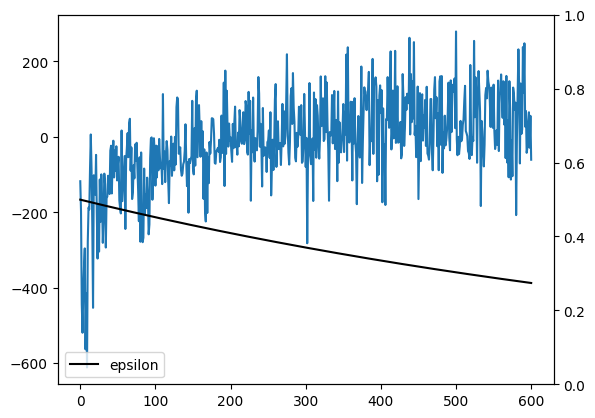

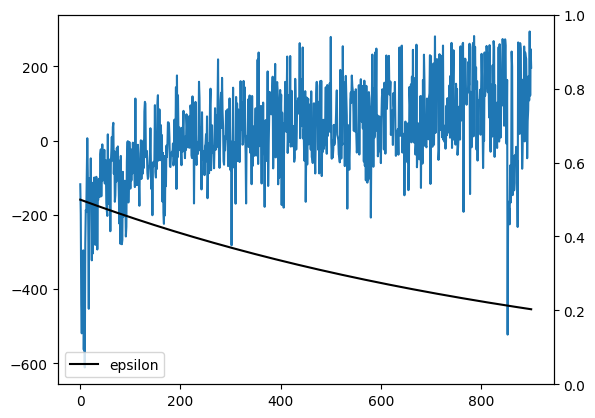

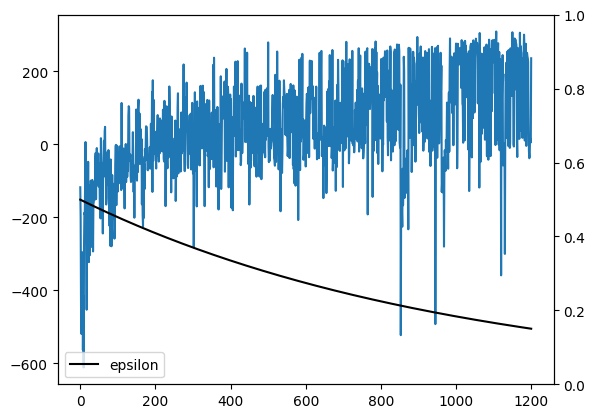

In [23]:
env = gym.make("LunarLander-v2")
agent3 = NeuralQLearningAgent(env, hidden=[128, 64], replay_memory=True, double_q=False, freezing=True)
rewards3 = run_agent_in_env(env, agent3, 1500, learning=True, plot=True, plot_interval=300)
print(torch.Tensor(rewards3).mean())

tensor(79.9005)


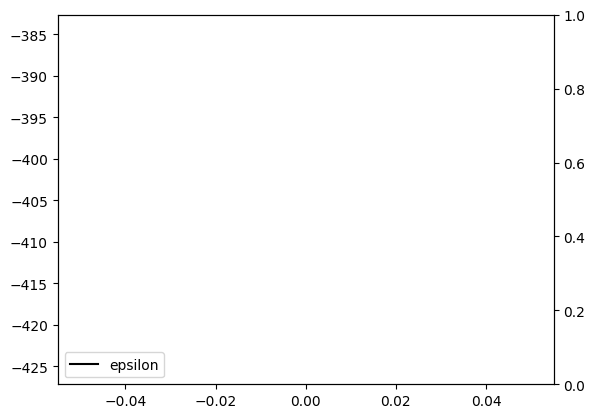

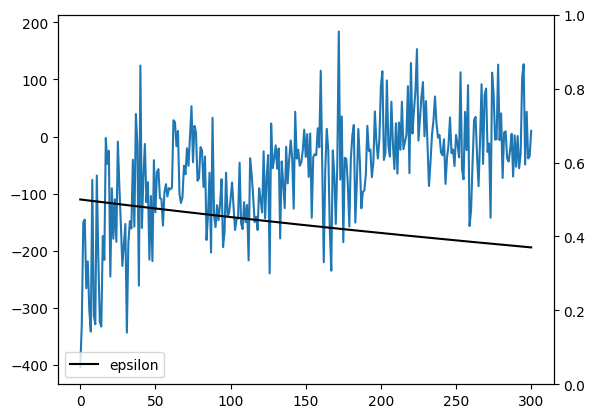

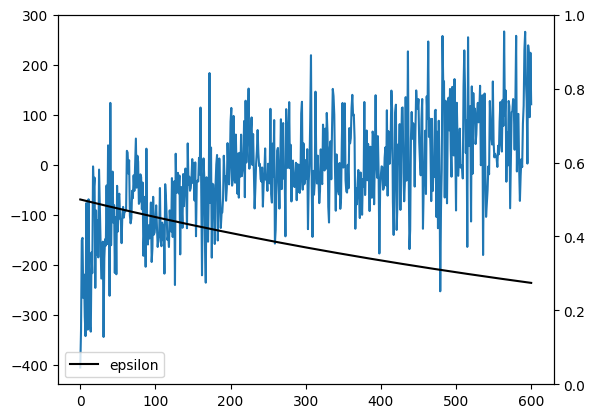

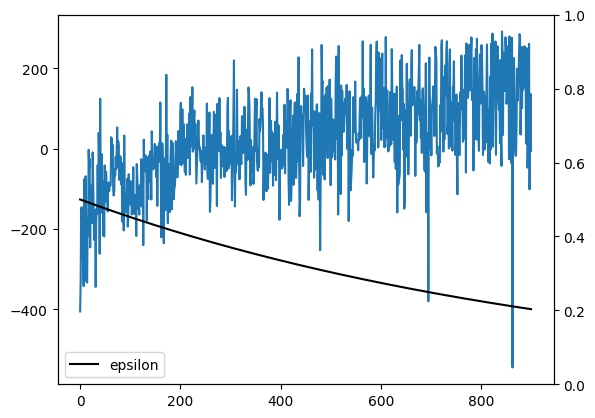

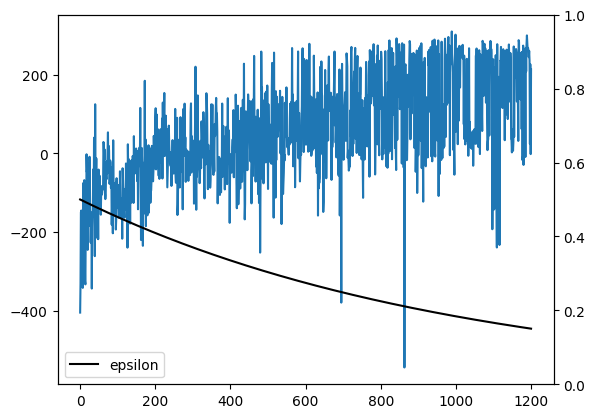

In [24]:
env = gym.make("LunarLander-v2")
agent4 = NeuralQLearningAgent(env, hidden=[128, 64], replay_memory=True, double_q=True, freezing=True)
rewards4 = run_agent_in_env(env, agent4, 1500, learning=True, plot=True, plot_interval=300)
print(torch.Tensor(rewards4).mean())